In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
import pandas as pd
import numpy as np

In [112]:
# download from https://www.kaggle.com/skillsmuggler/amazon-ratings
ratings = pd.read_csv('../data/ratings_Beauty.csv')

In [113]:
print(f"""
ratings.shape: {ratings.shape}
UserId cnt: {len(ratings['UserId'].unique())}
ProductId cnt: {len(ratings['ProductId'].unique())}
""")


ratings.shape: (2023070, 4)
UserId cnt: 1210271
ProductId cnt: 249274



In [114]:
ratings.dtypes

UserId        object
ProductId     object
Rating       float64
Timestamp      int64
dtype: object

In [115]:
ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [116]:
import datetime
# datetimeに変換
ratings['Timestamp'] = ratings['Timestamp'].map(lambda x: datetime.datetime.fromtimestamp(x))
print(f"from:{min(ratings['Timestamp'])}, max:{max(ratings['Timestamp'])}")

from:1998-10-19 00:00:00, max:2014-07-23 00:00:00


In [123]:
# データ量を削減
ratings = ratings[
    (ratings['Timestamp'].dt.year >= 2014)
    & (ratings['Timestamp'].dt.month >= 5)
]
print(f"""
ratings.shape: {ratings.shape}
UserId cnt: {len(ratings['UserId'].unique())}
ProductId cnt: {len(ratings['ProductId'].unique())}
""")


ratings.shape: (249263, 4)
UserId cnt: 173555
ProductId cnt: 79358



# 学習データ・テストデータ分割

In [124]:
# 期間で学習データ・テストデータ、説明変数・目的変数を分割する際に使用
start = min(ratings['Timestamp'])
end = max(ratings['Timestamp'])
interval = end - start
# 学習データとテストデータの分割
train = ratings[ratings['Timestamp'] <= (end - interval/3)]
test = ratings[ratings['Timestamp'] >= (start + interval/3)]
# 説明変数、目的変数の期間分割
train_y = train[train['Timestamp'] >= (start + interval/3)]
train_X = train[train['Timestamp'] < (start + interval/3)]
test_y = test[test['Timestamp'] >= (end - interval/3)]
test_X = test[test['Timestamp'] < (end - interval/3)]
# 説明変数、目的変数に共通するユーザー
train_tgt_user = set(train_X['UserId']) & set(train_y['UserId'])
test_tgt_user = set(test_X['UserId']) & set(test_y['UserId'])
print(f"""
train_X.shape: {train_X.shape}
test_X.shape: {test_X.shape}
""")


train_X.shape: (77700, 4)
test_X.shape: (83327, 4)



# 特徴量作成

In [125]:
def get_feature_by_user(df):
    """
    UserId単位の特徴量を取得する
    """
    res = list()
    for i, v in df.groupby('UserId'):
        res.append(
            (
                i,
                len(v['ProductId']),
                (v['Rating'] == 5).sum(),
                (v['Rating'] == 4).sum(),
                (v['Rating'] == 3).sum(),
                (v['Rating'] == 2).sum(),
                (v['Rating'] == 1).sum(),
                (v['Timestamp'].dt.dayofweek == 0).sum(),
                (v['Timestamp'].dt.dayofweek == 1).sum(),
                (v['Timestamp'].dt.dayofweek == 2).sum(),
                (v['Timestamp'].dt.dayofweek == 3).sum(),
                (v['Timestamp'].dt.dayofweek == 4).sum(),
                (v['Timestamp'].dt.dayofweek == 5).sum(),
                (v['Timestamp'].dt.dayofweek == 6).sum()
            )
        )
    
    res = pd.DataFrame(
        res,
        columns=[
            'UserId', 'p_cnt_u', 'rating_5_u', 'rating_4_u',
            'rating_3_u', 'rating_2_u', 'rating_1_u',
            'act_mon_u', 'act_tue_u', 'act_wed_u', 'act_thu_u',
            'act_fri_u', 'act_sat_u', 'act_sun_u'
        ])
    return res

In [126]:
def get_feature_by_product(df):
    """
    ProductId単位の特徴量を取得する
    """
    res = list()
    for i, v in df.groupby('ProductId'):
        res.append(
            (
                i,
                len(v['UserId']),
                (v['Rating'] == 5).sum(),
                (v['Rating'] == 4).sum(),
                (v['Rating'] == 3).sum(),
                (v['Rating'] == 2).sum(),
                (v['Rating'] == 1).sum(),
                (v['Timestamp'].dt.dayofweek == 0).sum(),
                (v['Timestamp'].dt.dayofweek == 1).sum(),
                (v['Timestamp'].dt.dayofweek == 2).sum(),
                (v['Timestamp'].dt.dayofweek == 3).sum(),
                (v['Timestamp'].dt.dayofweek == 4).sum(),
                (v['Timestamp'].dt.dayofweek == 5).sum(),
                (v['Timestamp'].dt.dayofweek == 6).sum()
            )
        )
    
    res = pd.DataFrame(
        res,
        columns=[
            'ProductId', 'u_cnt_p', 'rating_5_p', 'rating_4_p',
            'rating_3_p', 'rating_2_p', 'rating_1_p',
            'act_mon_p', 'act_tue_p', 'act_wed_p', 'act_thu_p',
            'act_fri_p', 'act_sat_p', 'act_sun_p'
        ])
    return res

In [127]:
# ユーザーごとの特徴量作成
train_X_u = get_feature_by_user(train_X)
test_X_u = get_feature_by_user(test_X)

In [128]:
# アイテムごとの特徴量作成
train_X_p = get_feature_by_product(train_X)
test_X_p = get_feature_by_product(test_X)

In [129]:
len(train_tgt_user), len(test_tgt_user)

(3549, 3311)

# 学習

In [142]:
def get_model_input(X_u, X_p, y, tgt_user):
    """
    LGBMRankerに入力するデータを取得する
    """
    merged = pd.merge(X_u, y, on=['UserId'], how='inner')
    merged = pd.merge(X_p, merged, on=['ProductId'], how='left')
    merged = merged.query('UserId in @tgt_user')
    # nullの場合は0で補完
    merged.fillna(0, inplace=True)
    features_cols = list(merged.drop(columns=['UserId', 'ProductId', 'Rating', 'Timestamp']).columns)
    # 検索クエリ
    query_list = merged['UserId'].value_counts()
    # UserId, ProductIdをインデックス化
    merged = merged.set_index(['UserId', 'ProductId'])
    # クエリリストをインデックスでソート
    query_list = query_list.sort_index()
    # 特徴量と目的変数データをインデックスでソート
    merged.sort_index(inplace=True)
    # 特徴量
    df_x = merged[features_cols]
    # 目的変数
    df_y = merged['Rating']
    
    return df_x, df_y, query_list

In [143]:
X_train, y_train, query_list_train = get_model_input(train_X_u, train_X_p, train_y, train_tgt_user)
X_test, y_test, query_list_test = get_model_input(test_X_u, test_X_p, test_y, test_tgt_user)

In [150]:
import lightgbm as lgb

model = lgb.LGBMRanker(n_estimators=1000, random_state=0)
model.fit(
    X_train,
    y_train,
    group=query_list_train,
    eval_set=[(X_test, y_test)],
    eval_group=[list(query_list_test)],
#     early_stopping_rounds=1
)

[1]	valid_0's ndcg@1: 0.94563	valid_0's ndcg@2: 0.968622	valid_0's ndcg@3: 0.975104	valid_0's ndcg@4: 0.97824	valid_0's ndcg@5: 0.979516
[2]	valid_0's ndcg@1: 0.951365	valid_0's ndcg@2: 0.970502	valid_0's ndcg@3: 0.976857	valid_0's ndcg@4: 0.979519	valid_0's ndcg@5: 0.981178
[3]	valid_0's ndcg@1: 0.94895	valid_0's ndcg@2: 0.9705	valid_0's ndcg@3: 0.976507	valid_0's ndcg@4: 0.979372	valid_0's ndcg@5: 0.98066
[4]	valid_0's ndcg@1: 0.949039	valid_0's ndcg@2: 0.969038	valid_0's ndcg@3: 0.975848	valid_0's ndcg@4: 0.978882	valid_0's ndcg@5: 0.980427
[5]	valid_0's ndcg@1: 0.950639	valid_0's ndcg@2: 0.97067	valid_0's ndcg@3: 0.977065	valid_0's ndcg@4: 0.97971	valid_0's ndcg@5: 0.98122
[6]	valid_0's ndcg@1: 0.951151	valid_0's ndcg@2: 0.969566	valid_0's ndcg@3: 0.976419	valid_0's ndcg@4: 0.979484	valid_0's ndcg@5: 0.980864
[7]	valid_0's ndcg@1: 0.949744	valid_0's ndcg@2: 0.970446	valid_0's ndcg@3: 0.9763	valid_0's ndcg@4: 0.97946	valid_0's ndcg@5: 0.980829
[8]	valid_0's ndcg@1: 0.948234	valid_0'

LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=-1,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
           random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Text(0.5, 1.0, 'feature importance')

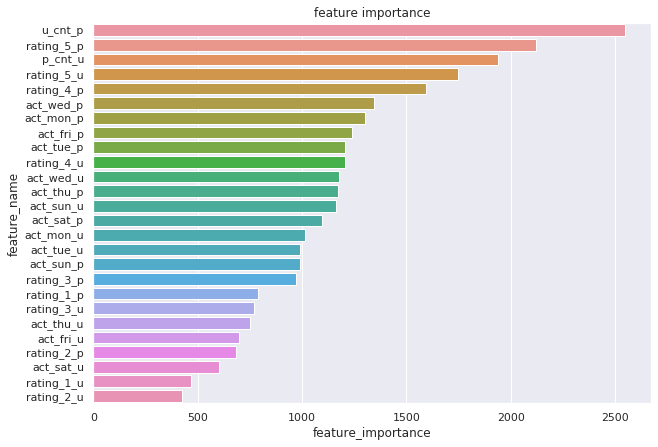

In [153]:
# 特徴量重要度
plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')

# 推論

In [182]:
def predict_at_k(data, model, k):
    """
    関連度が上位kのアイテムを予測する
    """
    user_ids = list()
    product_ids = list()
    ranks = list()
    
    for userId, df in data.groupby('UserId'):
        
        pred = model.predict(df.loc[userId])
        productId = np.array(df.reset_index()['ProductId'])
        topK_index = np.argsort(pred)[::-1][:k]
        product_ids.extend(list(productId[topK_index]))
        user_ids.extend([userId]*len(topK_index))
        ranks.extend(list(range(1, len(topK_index)+1)))

    results = pd.DataFrame({'UserId': user_ids, 'ProductId': product_ids, 'Rating': ranks})
    
    return results

In [183]:
predicted = predict_at_k(X_test, model, 10)

In [185]:
predicted['UserId'].value_counts()[:5]

A1TPW86OHXTXFC    5
A2D7IHQGEBIDNG    5
AKHV4Z5GQIE3X     5
AWFGKB5SCJAO2     5
A1KQNP8MOJDJKC    5
Name: UserId, dtype: int64

In [194]:
sample = 'A2D7IHQGEBIDNG'
print('[predicted]')
print(predicted.query(f'UserId == "{sample}"')[['ProductId', 'Rating']])
print('+'*20)
print('[actual]')
print(y_test[sample].sort_values(ascending=False))

[predicted]
       ProductId  Rating
1475  B00D5TB1LK       1
1476  B000W3QDJ2       2
1477  B008X0LUSA       3
1478  B000X1YING       4
1479  B006JYMHW0       5
++++++++++++++++++++
[actual]
ProductId
B00D5TB1LK    5.0
B008X0LUSA    5.0
B006JYMHW0    5.0
B000W3QDJ2    5.0
B00016XJ4M    5.0
B0071H5C76    4.0
B000X1YING    4.0
B007V8VFEE    3.0
Name: Rating, dtype: float64
